In [256]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F

%load_ext tensorboard
import torch.utils.tensorboard as tb
from torch.utils.tensorboard import SummaryWriter

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
zip_path = "/content/drive/MyDrive/A-Z Dataset/A_Z Handwritten Data.csv.zip"

In [7]:
with ZipFile(zip_path) as zipfile:
    zipfile.extractall()

In [8]:
csv_path = "/content/A_Z Handwritten Data.csv"

In [9]:
df = pd.read_csv(csv_path)

In [13]:
X = df.drop('0',axis = 1).to_numpy() # axis=1 is to say to drop along the columns
y = df['0'].to_numpy()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [31]:
# now take some for validation
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

In [34]:
class Alphabets(Dataset):

  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):
    
    image = Image.fromarray(((self.X[index]).astype(np.uint8)).reshape(28,28))
    label = self.y[index]

    if self.transform != None:
      image = self.transform(image)
    
    return image,label

In [236]:
transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.RandomAffine(
                    degrees=(-30,30), # turning the image within the specified degrees
                    translate=(0.2, 0.2), # moves the image horizontally and vertically 
                    scale=(0.7, 0.7) # this scales (randomly zooms in and zooms out or makes small or big the image) the image 
                  ),                   
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])


In [237]:
train_dataset = Alphabets(X_train,y_train,transform)
test_dataset = Alphabets(X_test,y_test,test_transform)
val_dataset = Alphabets(X_val,y_val,transform)

In [238]:
len(train_dataset),len(test_dataset),len(val_dataset)

(238368, 74490, 59592)

In [239]:
train_dataset_loader = DataLoader(train_dataset,batch_size=100,shuffle=True)
test_dataset_loader = DataLoader(test_dataset,batch_size=100,shuffle=True)
val_dataset_loader = DataLoader(val_dataset,batch_size=100,shuffle=True)

In [240]:
import torchvision

inputs_batch, labels_batch = next(iter(train_dataset_loader))
  
grid = torchvision.utils.make_grid(inputs_batch,nrow=40, pad_value=1)
torchvision.utils.save_image(grid, 'inputs_batch_preview.png')

In [241]:
config = [
  
    (1,16,3,1,1),
    ("MP",2,2,0),
    (16,32,3,1,1),
    ("MP",2,2,0),
    (32,64,3,1,1),
    ("MP",2,2,0),
    (64,128,3,1,1),
    ("MP",2,2,0),
    
]

In [242]:
def conv_output_size(img_size,padding,filter_size,stride,n_filters):
   size_ = (int((img_size + (2 * padding) - filter_size) / stride)) + 1
   return size_,size_,n_filters

In [243]:
def dense_layer_size(configuration,img_size):

  _,output_channels = 0,0
  layer_count = 0

  for config in configuration:
    
    layer_count += 1

    if config[0] == "MP":
      img_size,_,output_channels = conv_output_size(img_size,config[3],config[1],config[2],output_channels)
      print("Max Pooling Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)

    else: 
      img_size,_,output_channels = conv_output_size(img_size,config[4],config[2],config[3],config[1])
      print("Conv Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)
  
  return img_size,_,output_channels

In [244]:
width,heigth,channels = dense_layer_size(config,28)

Conv Layer 1 output dims ::  28 28 16
Max Pooling Layer 2 output dims ::  14 14 16
Conv Layer 3 output dims ::  14 14 32
Max Pooling Layer 4 output dims ::  7 7 32
Conv Layer 5 output dims ::  7 7 64
Max Pooling Layer 6 output dims ::  3 3 64
Conv Layer 7 output dims ::  3 3 128
Max Pooling Layer 8 output dims ::  1 1 128


In [245]:
width,heigth,channels

(1, 1, 128)

In [246]:
class NeuralNetwork(nn.Module):

  def __init__(self):
    super(NeuralNetwork,self).__init__()

    self.conv1 = nn.Conv2d(1,16,3,1,1)
    self.conv2 = nn.Conv2d(16,32,3,1,1)
    self.conv3 = nn.Conv2d(32,64,3,1,1)
    self.conv4 = nn.Conv2d(64,128,3,1,1)
    
    self.dropout = nn.Dropout2d(0.2)
  
    self.FC = nn.Linear(128,26)

  def forward(self,x):
    
    x = self.conv1(x)
    x = F.max_pool2d(x,2)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv2(x)
    x = F.max_pool2d(x,2)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv3(x)
    x = F.max_pool2d(x,2)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv4(x)
    x = F.max_pool2d(x,2)
    x = F.relu(x)
    x = self.dropout(x)

    x = torch.flatten(x,1)
    x = self.FC(x)

    return x 



In [247]:
net = NeuralNetwork()
net.train()

NeuralNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
  (FC): Linear(in_features=128, out_features=26, bias=True)
)

In [250]:
lr = 0.001
optim = torch.optim.Adam(net.parameters(),lr)
loss_fn = nn.CrossEntropyLoss()

In [251]:
epochs = 20
train_len = len(train_dataset_loader)
val_len = len(val_dataset_loader)

training_accuracy = []
training_loss = []

validation_accuracy = []
validation_loss = []

for epoch in range(epochs):

  epoch_acc = 0
  epoch_loss = 0

  for batch_id,(image,label) in enumerate(train_dataset_loader):

    output = net(image)

    loss = loss_fn(output,label)

    optim.zero_grad()
    loss.backward()
    optim.step()

    acc = (output.argmax(dim=1) == label).float().mean()
    epoch_acc += (acc.item() / len(train_dataset_loader)) * 100
    epoch_loss += (loss.item() / len(train_dataset_loader)) * 100

   
  print(f"Epoch :: [{epoch+1}/{epochs}] Step :: [{batch_id + 1}/{train_len}] Train Accuracy :: {epoch_acc:.4f} Train Loss :: {epoch_loss:.4f}") 


  training_accuracy.append(epoch_acc)
  training_loss.append(epoch_loss)

  with torch.no_grad():

    epoch_val_accuracy = 0
    epoch_val_loss = 0
    
    for batch_id,(image, label) in enumerate(val_dataset_loader):
  
      val_output = net(image)
      val_loss = loss_fn(val_output,label)
      
      val_acc = ((val_output.argmax(dim=1) == label).float().mean())
      epoch_val_accuracy += (val_acc.item() / len(val_dataset_loader)) * 100 
      epoch_val_loss += (val_loss.item() / len(val_dataset_loader)) * 100

      
    print(f"Epoch :: [{epoch+1}/{epochs}] Step :: [{batch_id + 1}/{val_len}] Val Accuracy :: {epoch_val_accuracy:.4f} Val Loss :: {epoch_val_loss:.4f}")

    validation_accuracy.append(epoch_val_accuracy)
    validation_loss.append(epoch_val_loss)
    


Epoch :: [1/20] Step :: [2384/2384] Train Accuracy :: 70.7499 Train Loss :: 97.3478
Epoch :: [1/20] Step :: [596/596] Val Accuracy :: 84.1247 Val Loss :: 52.9792
Epoch :: [2/20] Step :: [2384/2384] Train Accuracy :: 86.4578 Train Loss :: 44.8232
Epoch :: [2/20] Step :: [596/596] Val Accuracy :: 87.7165 Val Loss :: 40.7788
Epoch :: [3/20] Step :: [2384/2384] Train Accuracy :: 88.6918 Train Loss :: 37.7846
Epoch :: [3/20] Step :: [596/596] Val Accuracy :: 89.4732 Val Loss :: 35.3671
Epoch :: [4/20] Step :: [2384/2384] Train Accuracy :: 89.8120 Train Loss :: 34.1813
Epoch :: [4/20] Step :: [596/596] Val Accuracy :: 90.1576 Val Loss :: 33.1168
Epoch :: [5/20] Step :: [2384/2384] Train Accuracy :: 90.4946 Train Loss :: 32.0195
Epoch :: [5/20] Step :: [596/596] Val Accuracy :: 90.4503 Val Loss :: 32.3403
Epoch :: [6/20] Step :: [2384/2384] Train Accuracy :: 90.9292 Train Loss :: 30.8103
Epoch :: [6/20] Step :: [596/596] Val Accuracy :: 91.0643 Val Loss :: 29.9851
Epoch :: [7/20] Step :: [238

In [253]:
net.eval()

NeuralNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
  (FC): Linear(in_features=128, out_features=26, bias=True)
)

In [254]:
with torch.no_grad():

    epoch_test_acc = 0
    epoch_test_loss = 0
    
    for batch_id,(image, label) in enumerate(test_dataset_loader):
  
      test_output = net(image)
      test_loss = loss_fn(test_output,label)
      
      val_acc = ((test_output.argmax(dim=1) == label).float().mean())
      epoch_test_acc += (val_acc.item() / len(test_dataset_loader)) * 100 
      epoch_test_loss += (test_loss.item() / len(test_dataset_loader)) * 100
     
    print(f"Accuracy :: {epoch_test_acc:.4f}  Loss :: {epoch_test_loss:.4f}")


Accuracy :: 94.1223  Loss :: 19.6277


In [255]:
torch.save(net.state_dict(),"englishv8.pt")

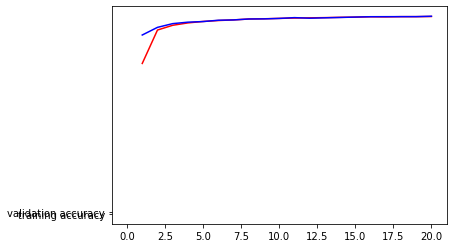

In [259]:
epochs_ = list(range(1,21))

plt.plot(epochs_,training_accuracy,"r","training accuracy")
plt.plot(epochs_,validation_accuracy,"b","validation accuracy")

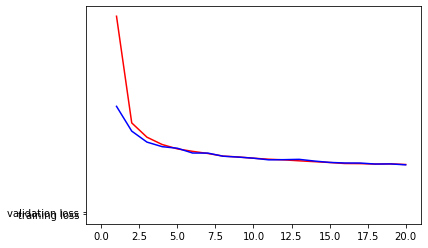

In [260]:
epochs_ = list(range(1,21))

plt.plot(epochs_,training_loss,"r","training loss")
plt.plot(epochs_,validation_loss,"b","validation loss")